In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
%matplotlib inline

In [2]:
grace = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/GRACE/GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc')

In [3]:
lon_in = np.where((grace.lon > 260) & (grace.lon < 280))[0]
lat_in = np.where((grace.lat > 20) & (grace.lat < 30))[0]

In [4]:
latis = [5,12,5,12,5,12]
lonis = [11,11,20,20,26,26]
gommean = grace.lwe_thickness[:,lat_in[latis],lon_in[lonis]].mean(dim=['lat','lon'])
gom_a = gommean - gommean.mean(dim='time')
gbp_a = gom_a.polyfit(dim='time', deg=1)
gbp_a_trend = xr.polyval(gom_a['time'], gbp_a.polyfit_coefficients)
gbp_a_detrend = gom_a - gbp_a_trend

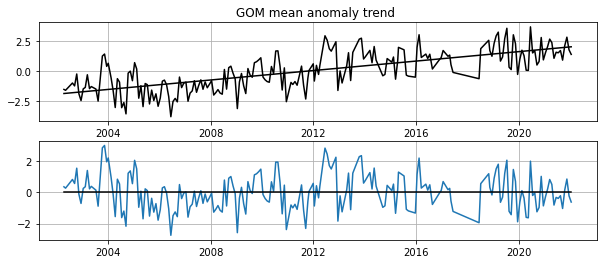

In [93]:
loni = 20; lati = 5; loni_2 = 20; lati_2 = 12; loni_3 = 11; lati_3 = 5;
loni_4 = 11; lati_4 = 12; loni_5 = 26; lati_5 = 5; loni_6 = 26; lati_6 = 12;
f, (ax,ax2) = plt.subplots(2,1,figsize=(10,4))
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati],lon_in[loni]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_2],lon_in[loni_2]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_3],lon_in[loni_3]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_4],lon_in[loni_4]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_5],lon_in[loni_5]])
# ax.plot(grace.time,grace.lwe_thickness[:,lat_in[lati_6],lon_in[loni_6]])
ax.plot(grace.time,gom_a,color='k')
ax.plot(grace.time,gbp_a_trend,color='k')
# ax.set_title(str(grace.lon[lon_in[loni]].data) + 'E, ' + str(grace.lat[lat_in[lati]].data) + 'N')
ax.set_title('GOM mean trend')
ax.grid()

ax2.plot(grace.time,gbp_a_detrend)
gbp_ad_trend = gbp_a_detrend.polyfit(dim='time', deg=1)
gbp_ad_trend = xr.polyval(gbp_a_detrend['time'], gbp_ad_trend.polyfit_coefficients)
ax2.plot(grace.time,gbp_ad_trend,color='k')
ax.set_title('GOM mean anomaly trend ')
ax2.grid()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_grace_trend.jpg', dpi=250)

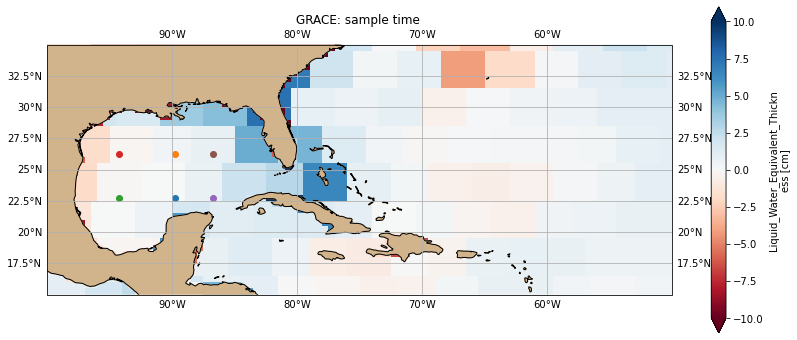

In [92]:
f, ax = plt.subplots(1,1,figsize=(14,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
tests = grace.lwe_thickness[2]
tests.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-10, vmax=10, cmap=plt.get_cmap('RdBu'))
ax.scatter(grace.lon[lon_in[loni]], grace.lat[lat_in[lati]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_2]], grace.lat[lat_in[lati_2]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_3]], grace.lat[lat_in[lati_3]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_4]], grace.lat[lat_in[lati_4]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_5]], grace.lat[lat_in[lati_5]],transform=ccrs.PlateCarree())
ax.scatter(grace.lon[lon_in[loni_6]], grace.lat[lat_in[lati_6]],transform=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
ax.set_title('GRACE: sample time ')
gl = ax.gridlines(draw_labels=True); 
ax.set_ylim([15,35]); ax.set_xlim([-100,-50])
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_grace_map.jpg', dpi=250)

In [114]:
grace.lwe_thickness

<xarray.DataArray 'lwe_thickness' (time: 205, lat: 360, lon: 720)>
array([[[-4.040082, -4.040082, ..., -4.040082, -4.040082],
        [-4.040082, -4.040082, ..., -4.040082, -4.040082],
        ...,
        [-0.980156, -0.980156, ..., -0.980156, -0.980156],
        [-0.980156, -0.980156, ..., -0.980156, -0.980156]],

       [[-4.762176, -4.762176, ..., -4.762176, -4.762176],
        [-4.762176, -4.762176, ..., -4.762176, -4.762176],
        ...,
        [-3.512018, -3.512018, ..., -3.512018, -3.512018],
        [-3.512018, -3.512018, ..., -3.512018, -3.512018]],

       ...,

       [[10.633545, 10.633545, ..., 10.633545, 10.633545],
        [10.633545, 10.633545, ..., 10.633545, 10.633545],
        ...,
        [ 5.775882,  5.775882, ...,  5.775882,  5.775882],
        [ 5.775882,  5.775882, ...,  5.775882,  5.775882]],

       [[11.473664, 11.473664, ..., 11.473664, 11.473664],
        [11.473664, 11.473664, ..., 11.473664, 11.473664],
        ...,
        [ 3.262696,  3.262696, ...,  3.262696,  3.262696],
        [ 3.262696,  3.262696, ...,  3.262696,  3.262696]]])
Coordinates:
  * lon      (lon) float64 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 2002-04-17T12:00:00 ... 2022-01-16T12:00:00
Attributes:
    units:          cm
    long_name:      Liquid_Water_Equivalent_Thickness
    standard_name:  Liquid_Water_Equivalent_Thickness
    grid_mapping:   WGS84
    valid_min:      -1818.5595693006699
    valid_max:      829.9815182106363
    comment:        Coastline Resolution Improvement (CRI) filter is applied

In [20]:
gobp = grace.lwe_thickness.sel(time=slice("2008-01-01", "2017-12-31"))/100
pgobp = gobp.polyfit(dim='time', deg=1)
gobp_trend = pgobp.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365

/var/folders/g_/xh2hxbd10wl4stb5spmwldj00000gn/T/ipykernel_44404/3513937955.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


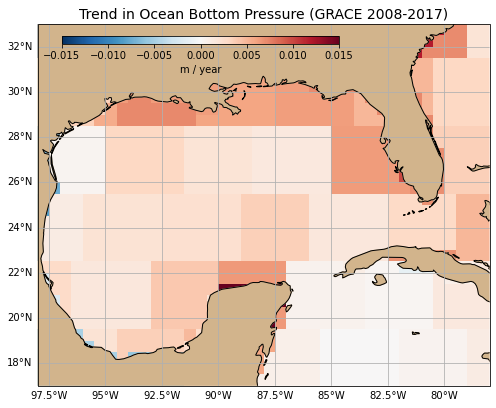

In [36]:
lon_w = -98; lon_e = -78; 
lat_s = 17; lat_n = 33; 
f, ax = plt.subplots(1,1,figsize=(7,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cc = gobp_trend.plot(ax=ax,transform=ccrs.PlateCarree(), vmin=-0.015, vmax=0.015, cmap=plt.get_cmap('RdBu_r'),add_colorbar=False)
ax.set_title('Trend in Ocean Bottom Pressure (GRACE 2008-2017)',fontsize=14)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;
# ax.set_ylim([10,55]); ax.set_xlim([-100,-40])
# ax.set_xlim([-98,-80]); ax.set_ylim([18,31]);
ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
cbpos = [0.13, 0.87, 0.55, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='horizontal', label='m / year')
ax.grid()
plt.tight_layout()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/grace_obp_trend.jpg', dpi=250)